In [109]:
import os, sys, glob
import numpy as np
from numba import njit
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import minimize

from tqdm.notebook import tqdm

from utils import prepare_simulation, prepare_data, interp_hist, angular_distance

In [110]:
source_ra = 40.67 # degrees
source_dec =-0.003 # degrees

In [111]:
# Gather the simulated events
sim = prepare_simulation(source_ra, source_dec, # degrees
                           window = 5, # degrees
                           E0 = 1000, # GeV,
                           gamma = 2,
                           time_mean = 57000,
                           time_sigma = 100,
                           simfile = "/data/mjlarson/datasets/ps_tracks/version-004-p00/IC86_2016_MC.npy")

In [4]:
# And grab the data
data = prepare_data()

# Moving out of binned histograms
The previous examples have relied on binned histograms. There's good reasons to 
use them sometimes (they're easy to work with and can lead to significantly faster
fitting (especially if $N_events >> N_bins$, like you get in gamma rays). There is
a method that's more sensitive in general, though. Let's go back to the beginning.

We believe our data histogram $k$ is some combination of the signal histogram $S$ 
and background histogram $B$ so that

> $k = (\hat{N}_b * B) + (\hat{N}_s * S)$

We'll take this a step further and define the likelihood as the ratio of the expected 
value to the data

> $\mathcal{L}(N_b, N_s) = (\frac{N_b}{N} * B) + (\frac{N_s}{N} * S)$

Like in the last example with a $\Delta\chi^2$, we want to compare likelihood values
both with and without signal. In this case, we'll take the ratio between the two:

> $\mathcal{L}(N_b N_S)/\mathcal{L}(N'_b, N_S=0) = ((\frac{N_b}{N} * B) + (\frac{N_s}{N} * S))$ / $(\frac{N'_b}{N} * B))$

> $\mathcal{L}(N_b, N_S)/\mathcal{L}(N'_b, N_S=0) = \frac{N_b}{N'_b} + \frac{N_s}{N'_b} \frac{S}{B}$

We can now add a simplifying assumption that $N=k$. Since $B$ and $S$ encode
probabilities, we end up with $N=N'_b=N_b+N_s$. We can substitute for $N_b$ and $N'_b$, reducing our number of free parameters.

> $\mathcal{L}(N_b, N_S)/\mathcal{L}(N'_b, N_S=0) = \frac{N-N_s}{N} + \frac{N_s}{N-N_s} \frac{S}{B}$

> $\mathcal{L}(N_S)/\mathcal{L}(N_S=0) = 1 - \frac{N_s}{N} + \frac{N_s}{N} \frac{S}{B}$

> $\mathcal{L}(N_S)/\mathcal{L}(N_S=0) = 1 + \frac{N_s}{N} \left(\frac{S}{B}-1\right)$

We typically use the (natural) log of this all to get

> $\Delta ln(\mathcal{L}) = ln(\frac{N_s}{N}\left(\frac{S}{B}-1\right) + 1)$

This is the standard form of the *likelihood ratio* (often just generally referred to
as the "test statistic") and is the basis for most fits you'll see doing astronomy in 
IceCube. Sometimes you'll see an extra factor of 2 floating around in this: this factor
does not matter for anything we do, but can make some approximations simpler for people
who are too lazy to run enough trials. Ask later if you want to know more.

Let's look at an implementation of this all.

# The background likelihood term B

This is the first term we need and luckily it's pretty simple. We will make a 
histogram of the data values in sin(dec), turning on the `density` property in
`np.histogram` so that we get a PDF.

Background is assumed to be uniform in RA (see `histogramming.ipynb` for an 
explanation), so we only need declination for the spatial term of the background.

Text(0, 0.5, 'B')

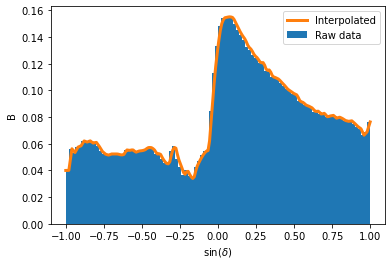

In [94]:
# histogram the data to get the bg pdf?
fig, ax = plt.subplots()
B, B_bins = np.histogram(np.sin(data['dec']), 
                         bins=100)

# Convert this to an estimate of probability density
# (so divide by the bin width in solid angle and by 
# the the number of events)
B = B.astype(float) / (np.diff(B_bins) * (2*np.pi) * B.sum())

_ = ax.hist(B_bins[:-1],
            bins=B_bins,
            weights=B,
            linewidth=3,
            label='Raw data')

# We can evaluate it using an interpolate function. Here, I've
# wrapped np.interp into a interp_hist function. This function
# only works in 1d.
newb = np.linspace(B_bins[0], B_bins[-1], 200)
interpolated = interp_hist(newb, B, B_bins)
ax.plot(newb, interpolated,
        linewidth=3,
        label='Interpolated',)
                  
ax.legend()
ax.set_xlabel(r"sin($\delta$)")
ax.set_ylabel("B")

# The signal likelihood term S

The signal likelihood is different. Here, we expect the hits to be clustered 
in both declination and right ascension. Instead of making the signal PDF as
an interpolated declination pdf, let's just use a (symmetric 2D) Gaussian.

With our simulation, we can calculate the angular distance between the truth
and the reconstructed values using a pre-defined `angular_distance` function.
We can also grab the reconstructed angular uncertainty, labeled `angErr` in
the data and simulation files.

Note that the reconstructed angular uncertainty is *not* the same as the distance
between the true and reconstruction. Instead, `angErr` gives us what information
about the accuracy the reconstruction algorithm itself believes it obtains based
on the available hit information. Try to keep these separate in your mind so you
can avoid being confused!

Once we have the reconstructed direction $\vec{\Phi}$ and reconstructed angular 
uncertainty $\sigma_i$, we can define the signal spatial likelihood $S_i$ for 
each event 

>  $ S_i(\vec{\Phi}, \sigma_i) = \frac{1}{2 \pi \sigma_i^2}\; exp\left(-\frac{1}{2}\left(\frac{\vec{\Phi}_i}{\sigma_i}\right)^2\right)$

In [106]:
def gaussian(phi, sigma):
    return 1/(2*np.pi*sigma**2) * np.exp(-0.5 * (phi/sigma)**2)

# Building the likelihood

Now let's put things together in a function so we can calculate the TS.

In [107]:
def get_ts(source_ra_radians,
           source_dec_radians,
           observed, 
           B, B_bins, 
           N_s, S, S_bins):
    
    phi = angular_distance(source_ra_radians, source_dec_radians,
                                    observed['ra'], observed['dec'])
    observed_S = gaussian(phi, observed['angErr'])
    observed_B = interp_hist(np.sin(observed['dec']), B, B_bins)

    SoB = observed_S / observed_B
    SoB[~np.isfinite(SoB)] = 0
        
    with np.errstate(divide='ignore'):
        ts = np.log(1 + (N_s/len(observed)) * (SoB - 1))
        return -ts.sum()


In [108]:
# Let's try it.
fit_func = lambda params: get_ts(np.radians(source_ra),
                                np.radians(source_dec),
                                data,
                                B=B, B_bins=B_bins,
                                N_s=params[0], S=S, S_bins=S_bins)

results = minimize(fit_func, 
                   x0 = [1.0, ],
                   bounds = [[0, 1000]])

print(results)

      fun: -16.510078457448948
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00812364])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 62
      nit: 7
     njev: 31
   status: 0
  success: True
        x: array([73.96082434])
